## Initialize

In [ ]:
import os
# os module provides functions for interacting with the operating system, e.g., creating and removing a directory
import numpy as np
# for mathematic computing
import matplotlib.pyplot as plt
# for ploting
import itertools
import pandas as pd
from scipy import stats
import math
try:
    import nilearn
except ImportError:
    !pip install nilearn

     |████████████████████████████████| 4.9 MB 4.9 MB/s 


In [ ]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"

# os.path.isdir: to check if path is an existing directory; os.mkdir: create a directory
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasser parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in seconds

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated twice in each subject
N_RUNS = 2

# There are 7 tasks. Each has a number of 'conditions'

# ----------------------------------------------------------------------------------------------------------------------------------------
# -----------------NOTE: We only got the block-design data, which includes 2 conditions : loss and win --------------------
# ----------------------------------------------------------------------------------------------------------------------------------------
# I think we can delete other expeirment task and only keep the gambling one to reduce downloading time 
EXPERIMENTS = {
    'GAMBLING'   : {'runs': [11,12], 'cond':['loss_event','win_event','neut_event','loss','win']},}
# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

## Downloading data

The task data are shared in different files, but they will unpack into the same directory structure.


In [ ]:
fname = "hcp_task.tgz"
# if there is no such file (hcp_task.tgz), get to the link and download the file to HCP directory ("./hcp")
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [ ]:
fname = f"{HCP_DIR}/atlas.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/j5kuc/download

## Loading region information

Downloading this dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).



In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

the [parcellation on the fsaverage5 surface](https://figshare.com/articles/HCP-MMP1_0_projected_on_fsaverage/3498446) and approximate MNI coordinates of each region, which can be useful for visualization:

In [ ]:
with np.load(f"{HCP_DIR}/atlas.npz") as dobj:
  atlas = dict(**dobj)

## Helper functions

1. loading the time series from a single suject and a single run
2. loading an EV file for each task. 
3. averaging all frames from any given condition.

An EV file (EV:Explanatory Variable) describes the task experiment in terms of stimulus onset, duration, and amplitude. These can be used to model the task time series data.

LR and RL are two runs with the block order counterbalance

In [ ]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int):      0-based subject ID to load
    experiment (str):   Name of experiment 
    run (int):          0-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean (typically the mean BOLD signal is not of interest)

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_run  = EXPERIMENTS[experiment]['runs'][run]
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  
  # we can directly load any files with np.load 
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, experiment, run):
  """Load EVs (explanatory variables) data for one task experiment.

  Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = 'tfMRI_'+experiment+'_'+['RL','LR'][run]
  for cond in EXPERIMENTS[experiment]['cond']:    
    ev_file  = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list


# averages all frames from any given condition
def average_frames(data, evs, experiment, cond):    
    idx = EXPERIMENTS[experiment]['cond'].index(cond)
    return np.mean(np.concatenate([np.mean(data[:,evs[idx][i]],axis=1,keepdims=True) for i in range(len(evs[idx]))],axis=-1),axis=1)


# use the gammma hrf
def double_gamma_hrf(response_delay=6, undershoot_delay=12, response_dispersion=0.9, undershoot_dispersion=0.9, response_scale=1, undershoot_scale=0.035, temporal_resolution=int(np.ceil(1/TR)),):
  hrf_length = 30  # How long is the HRF being created
  """Create the double gamma HRF with the timecourse evoked activity. Default values are based on Glover, 1999 and Walvaert, Durnez, Moerkerke, Verdoolaege and Rosseel, 2011
    Parameters
    ----------
    response_delay : float; How many seconds until the peak of the HRF
    undershoot_delay : float; How many seconds until the trough of the HRF
    response_dispersion : float; How wide is the rising peak dispersion
    undershoot_dispersion : float; How wide is the undershoot dispersion
    response_scale : float; How big is the response relative to the peak
    undershoot_scale :float; How big is the undershoot relative to the trough
    scale_function : bool; Do you want to scale the function to a range of 1
    temporal_resolution : float; How many elements per second are you modeling for the stimfunction
    Returns
    ----------
    hrf : multi dimensional array
        A double gamma HRF to be used for convolution.
    """


    # How many seconds of the HRF will you model?
  hrf = [0] * int(hrf_length * temporal_resolution)

    # When is the peak of the two aspects of the HRF
  response_peak = response_delay * response_dispersion
  undershoot_peak = undershoot_delay * undershoot_dispersion

  for hrf_counter in list(range(len(hrf) - 1)):
    # Specify the elements of the HRF for both the response and undershoot
    resp_pow = math.pow((hrf_counter / temporal_resolution) / response_peak, response_delay)      
        
    resp_exp = math.exp(-((hrf_counter / temporal_resolution) -
                              response_peak) /
                            response_dispersion)

    response_model = response_scale * resp_pow * resp_exp

    undershoot_pow = math.pow((hrf_counter / temporal_resolution) /
                                  undershoot_peak,
                                  undershoot_delay)
    undershoot_exp = math.exp(-((hrf_counter / temporal_resolution) -
                                    undershoot_peak /
                                    undershoot_dispersion))

    undershoot_model = undershoot_scale * undershoot_pow * undershoot_exp

        # For this time point find the value of the HRF
    hrf[hrf_counter] = response_model - undershoot_model

  return hrf

# Create design martix for each subjects
def get_design_matrix(subject, experiment, run):
  #load evs, data and hrf
  evs = load_evs(subject, experiment,run)
  data = load_single_timeseries(subject,experiment,run,remove_mean=True)
  hrf=double_gamma_hrf()
  
  # create a event array (regressor) for each feedback condition 
  InitialVextor=np.zeros(data.shape[1])
  for i in range(0,len(evs[0])):
    InitialVextor[evs[0][i]]=1;
  loss=InitialVextor;
  
  InitialVextor=np.zeros(data.shape[1])
  for i in range(0,len(evs[1])):
    InitialVextor[evs[1][i]]=1;
  win=InitialVextor;
  
  InitialVextor=np.zeros(data.shape[1])
  for i in range(0,len(evs[2])):
    InitialVextor[evs[2][i]]=1;
  neu=InitialVextor;
  
  #convolve regressors with the HRF
  n   = len(loss)
  ev1 = np.convolve(loss,hrf,'full')[:n]
  n   = len(win)
  ev2 = np.convolve(win,hrf,'full')[:n]
  n   = len(neu)
  ev3 = np.convolve(neu,hrf,'full')[:n]
  
  # demean the task regressors
  ev1 = ev1 - np.mean(ev1)
  ev2 = ev2 - np.mean(ev2)
  ev3 = ev3 - np.mean(ev3)
  
  # append a constant regressor
  design_matrix = np.asarray([ev1,ev2,ev3,np.ones_like(ev1)]).T
  
  return design_matrix

# GLM function from FSL dataset codes
def glm(Y,X,C=None,mask=None):
  """
  Run a general linear model

  Args:
    Y (2d array) : time-by-space data matrix
    X (2d array) : time-by-regressors design matrix
    C (2d array) : contrasts-by-regressor contrrast matrix [default=Identity]
    mask (1d array) : spatial mask where GLM is run

  Returns:    
    contrast maps
    t-stats
  """
  if C is None:
    C = np.identity(X.shape[1])
  if mask is None:
    mask = np.ones(Y.shape[1])

  # initialise matrices
  beta    = np.zeros((X.shape[1],Y.shape[1]))
  cope    = np.zeros((C.shape[0],Y.shape[1]))
  varbeta = np.zeros_like(beta)
  tstat   = np.zeros_like(beta)

  # solve glm
  beta[:,mask>0] = np.linalg.pinv(X)@Y[:,mask>0]
  # apply contrasts
  cope[:,mask>0] = np.dot(C,beta[:,mask>0])

  # calculate uncertainty (varcope)
  r    = Y - X@beta
  dof  = X.shape[0] - np.linalg.matrix_rank(X)
  sig2 = np.sum(r**2,axis=0)/dof
  varcope = np.outer(C@np.diag(np.linalg.inv(X.T@X))@C.T,sig2)


  return cope, varcope

## Create & plot design matrix for single subject

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


Text(0.5, 1.1903670938520323, 'Event-related design matrix')

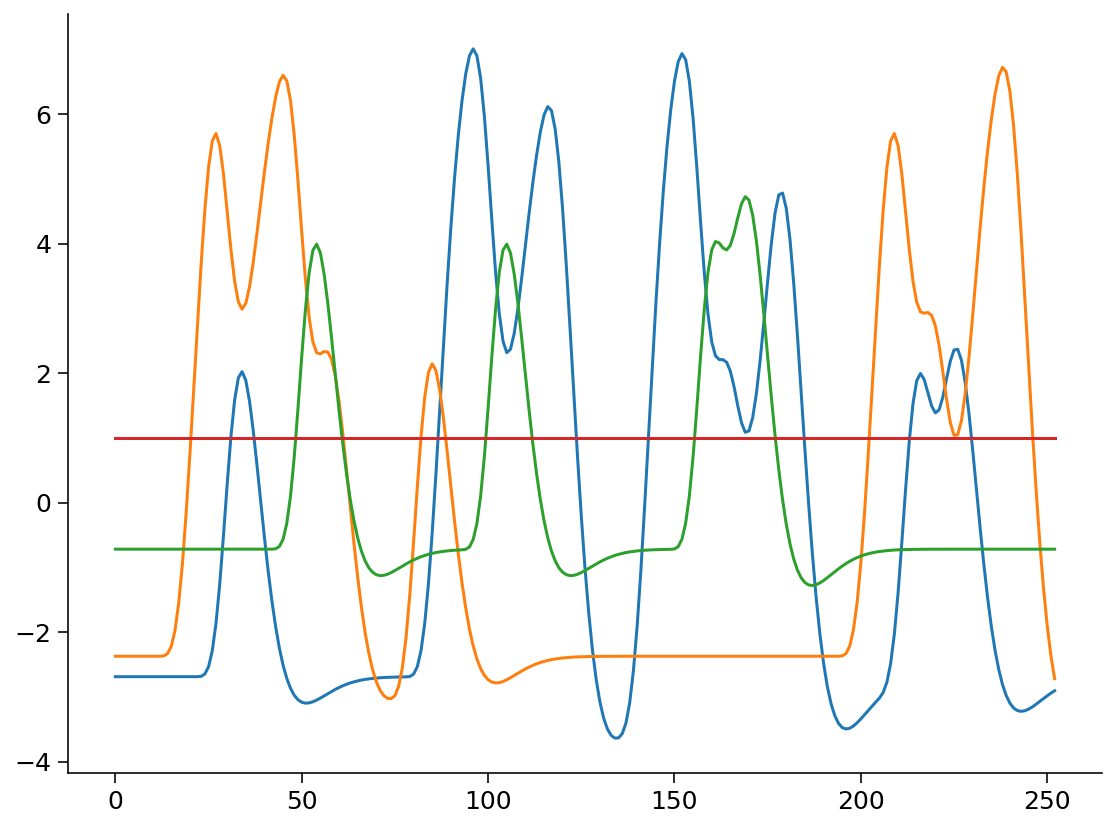

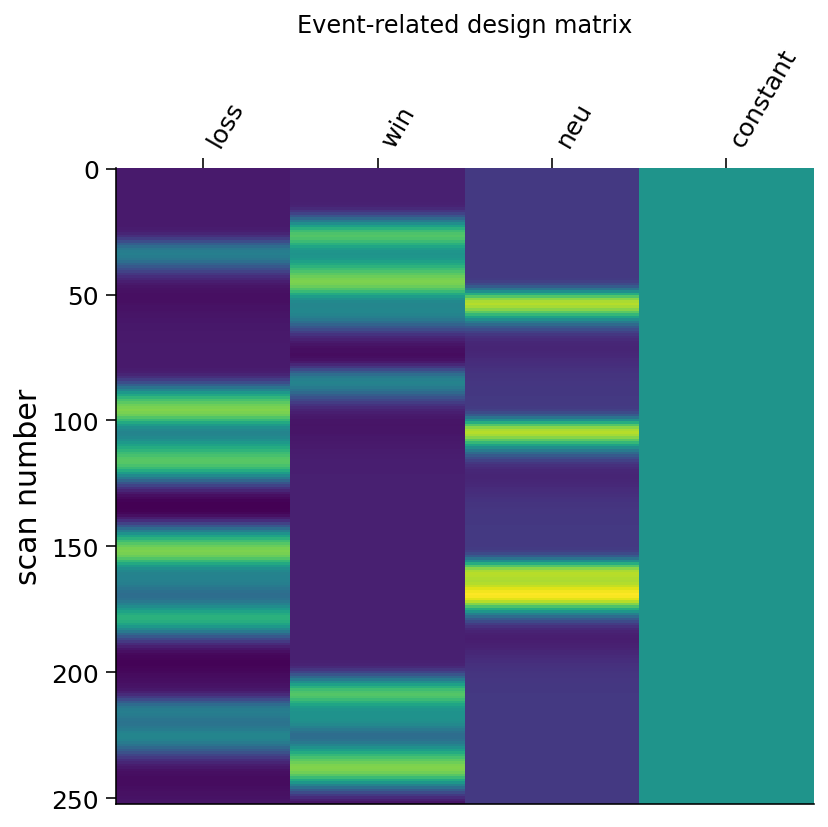

In [ ]:
my_exp  = 'GAMBLING'
my_subj = 2
my_run=0
design_matrix=get_design_matrix(subject=my_subj, experiment=my_exp, run=my_run)
plt.plot(design_matrix)
X1 = pd.DataFrame({'loss':design_matrix[:,0], 'win': design_matrix[:,1],
                       'neu': design_matrix[:,2], 'constant': design_matrix[:,3]})
from nilearn.plotting import plot_design_matrix
fig, (ax1) = plt.subplots(figsize=(6, 6), nrows=1, ncols=1)
plot_design_matrix(X1, ax=ax1)
ax1.set_title('Event-related design matrix', fontsize=12)


## First-Level analysis

In [ ]:
data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)
# Fitting a first level model (GLM)
# create a mask where data is non-zero
Y = data.T
mask = np.sum(Y**2,axis=0)>0
beta,betavar = glm(Y=Y,X=design_matrix,mask=mask)

Single subject exmaple.

In [ ]:
s=1
r=0
data = load_single_timeseries(subject=s,experiment=my_exp,run=r,remove_mean=True)
design_matrix=get_design_matrix(subject=s,experiment=my_exp,run=r)

Y = data.T
mask = np.sum(Y**2,axis=0)>0

# run GLM
beta,betavar = glm(Y=Y,X=design_matrix,mask=mask)
loss_activity = beta[0]
win_activity = beta[1]
neu_activity = beta[2]

loss_winc   = (beta[0] - beta[1]) / np.sqrt(betavar[0]+betavar[1])
win_lossc   = (beta[1] - beta[0]) / np.sqrt(betavar[1]+betavar[0])
loss_neuc  = (beta[0] - beta[2]) / np.sqrt(betavar[0]+betavar[1])
win_neuc   = (beta[1] - beta[2]) / np.sqrt(betavar[0]+betavar[1])

Group analysis

In [ ]:
my_exp  = 'GAMBLING'
# get the group averaged beta diff map for all subjects 
loss_win_groupc=np.zeros((360,339))
win_loss_groupc=np.zeros((360,339))
loss_neu_groupc=np.zeros((360,339))
win_neu_groupc=np.zeros((360,339))

# loop wihin all subjects 
for s in subjects:
  for r in [0,1]:
    data = load_single_timeseries(subject=s,experiment=my_exp,run=r,remove_mean=True)
    design_matrix=get_design_matrix(subject=s,experiment=my_exp,run=r)
    
    Y = data.T
    mask = np.sum(Y**2,axis=0)>0

    # run GLM
    beta,betavar = glm(Y=Y,X=design_matrix,mask=mask)
 
    # add the individual result to group array using +=
    loss_win_groupc[:,s]        += (beta[0] - beta[1]) / np.sqrt(betavar[0]+betavar[1])
    win_loss_groupc[:,s]         += (beta[1] - beta[0]) / np.sqrt(betavar[1]+betavar[0])
    loss_neu_groupc[:,s]        += (beta[0] - beta[2]) / np.sqrt(betavar[0]+betavar[1])
    win_neu_groupc[:,s]         += (beta[1] - beta[2]) / np.sqrt(betavar[0]+betavar[1])

## Second-level analysis

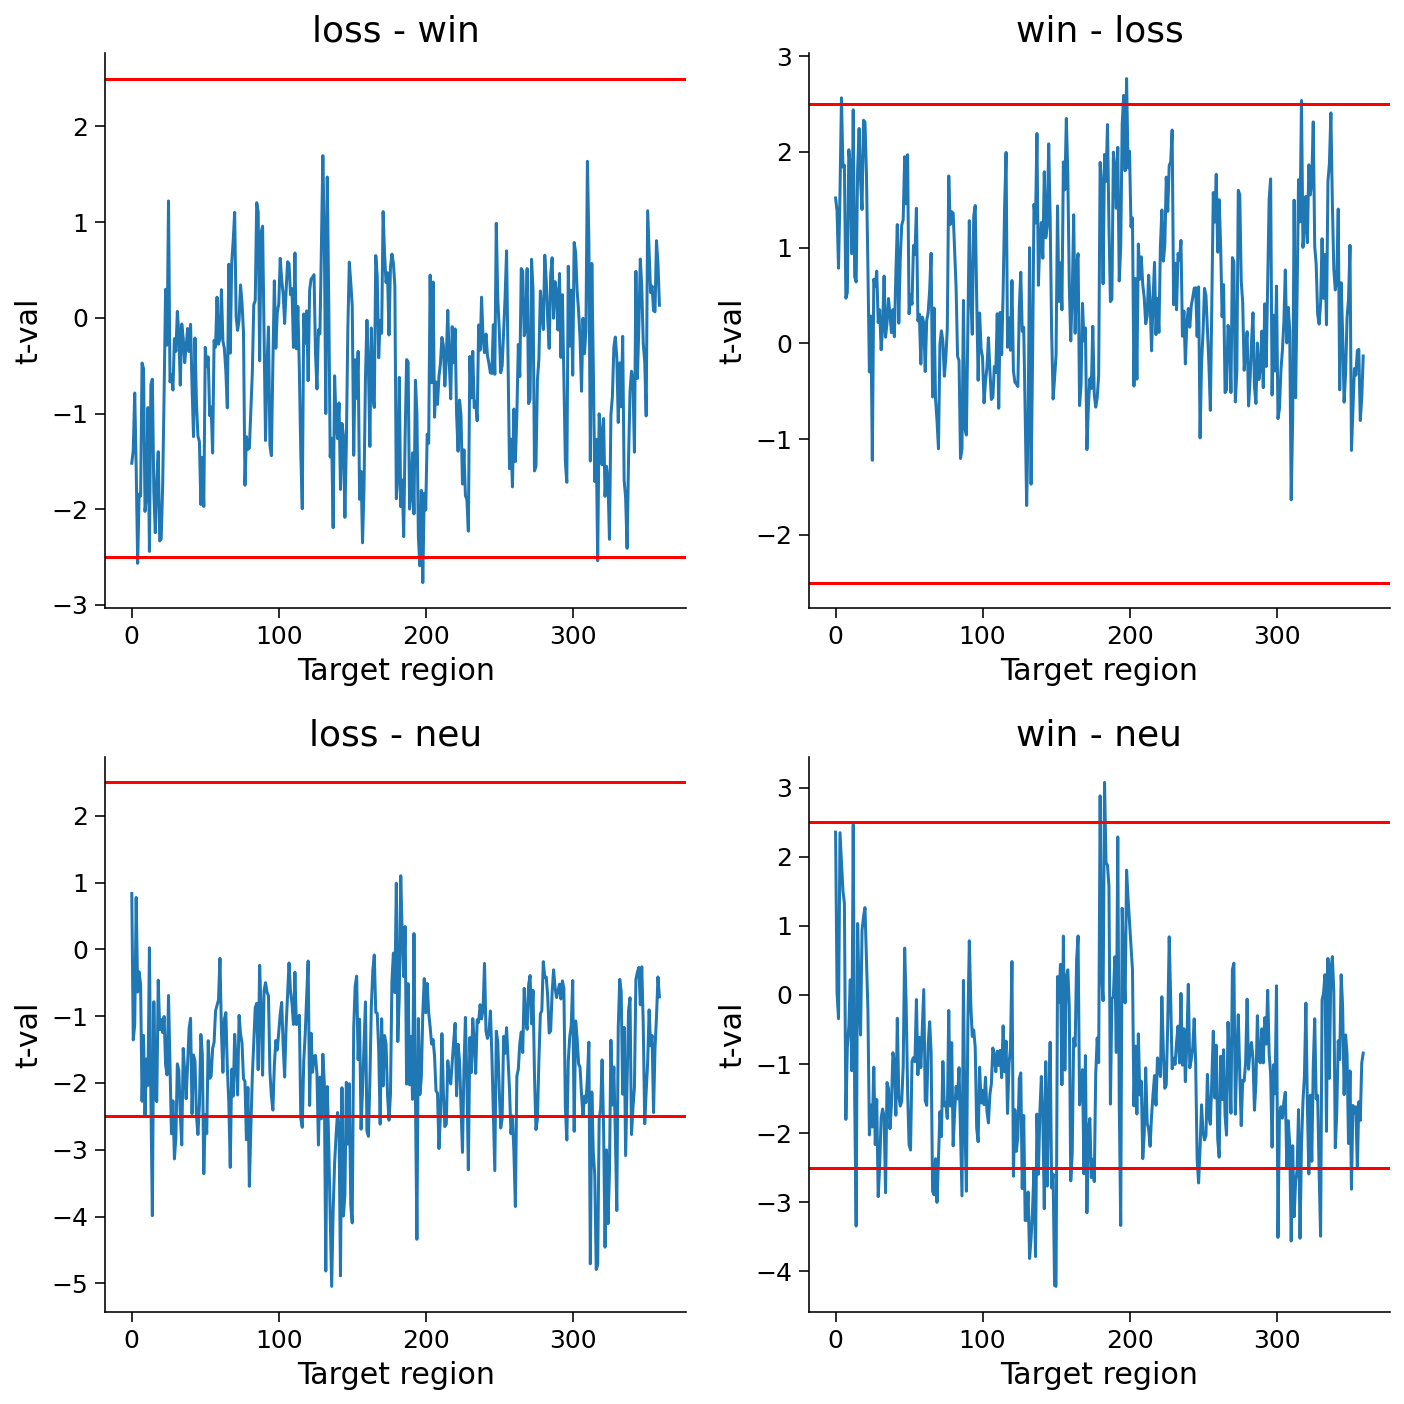

<Figure size 648x504 with 0 Axes>

<Figure size 648x504 with 0 Axes>

In [ ]:
# plot the result with diff regions 
loss_win_second=np.mean(loss_win_groupc, axis=1)
win_loss_second=np.mean(win_loss_groupc, axis=1)
loss_neu_second=np.mean(loss_neu_groupc, axis=1)
win_neu_second=np.mean(win_neu_groupc, axis=1)

fig, (ax1, ax2) = plt.subplots(figsize=(10, 10), nrows=2, ncols=2)
plt.subplot(2, 2, 1)
plt.plot(loss_win_second)
plt.axhline(y=2.5, color='r', linestyle='-')
plt.axhline(y=-2.5, color='r', linestyle='-')
plt.title("loss - win")
plt.xlabel("Target region")
plt.ylabel("t-val")

plt.subplot(2, 2, 2)
plt.plot(win_loss_second)
plt.title("win - loss")
plt.axhline(y=2.5, color='r', linestyle='-')
plt.axhline(y=-2.5, color='r', linestyle='-')
plt.xlabel("Target region")
plt.ylabel("t-val")

plt.subplot(2, 2, 3)
plt.plot(loss_neu_second)
plt.axhline(y=2.5, color='r', linestyle='-')
plt.axhline(y=-2.5, color='r', linestyle='-')
plt.title("loss - neu")
plt.xlabel("Target region")
plt.ylabel("t-val")

plt.subplot(2, 2, 4)
plt.plot(win_neu_second)
plt.axhline(y=2.5, color='r', linestyle='-')
plt.axhline(y=-2.5, color='r', linestyle='-')
plt.title("win - neu")
plt.xlabel("Target region")
plt.ylabel("t-val")

plt.show()
plt.rcParams["figure.figsize"] = (20,20)
plt.figure(figsize=(9, 7))


RDM 

In [ ]:
loss_win_second=np.mean(loss_win_groupc, axis=1)
win_loss_second=np.mean(win_loss_groupc, axis=1)
loss_neu_second=np.mean(loss_neu_groupc, axis=1)
win_neu_second=np.mean(win_neu_groupc, axis=1)
rois =[]

rois1 = [loss_win_second]
rois2 = [win_loss_second]
rois3 = [loss_neu_second]
rois4 = [win_neu_second]
rois.append(rois1)
rois.append(rois2)
rois.append(rois3)
rois.append(rois4)
#print(rois)
# i basically have to created an array put all the ROIs 
roiiguess = np.array([win_loss_second,loss_win_second,loss_neu_second,win_neu_second])
print(win_loss_second.shape)
#print(categories,len(rois))
categories1= ['loss_win']
categories2 = ['win_loss']
categories3 = ['loss_neutral']
categories4 = ['win_neutral']


(360,)


In [ ]:
"""constants"""

# Load the data
# Make sure you edit the following line to reflect the directory where you are accessing the dataset
# dir = '/gpfs/milgram/data/cmhn-s18/datasets/Ninetysix/'  # Yale
# dir = '/jukebox/pniintel/brainiak_edu/datasets/NinetySix/'  # Princeton
ns_data_dir = '/content/hcp/subjects/1/timeseries/bold11_Atlas_MSMAll_Glasser360Cortical.npy'
all_subj_initials = subjects
#rois_to_remove = region_info['name'] - rois_to_keep
rois_to_keep = rois
#['R_a47r','R_SCEF','R_11l','R_OFC','R_IFJp']


def load_data_for_a_subj(subject):
    #assert subj_initials in all_subj_initials
    #images = scipy.io.loadmat(
        #os.path.join(ns_data_dir, '%s_images.mat' % (subj_initials))
    #)['images']  
    data = '/content/hcp/subjects/1/timeseries/bold11_Atlas_MSMAll_Glasser360Cortical.npy'
 
    # unpack metadata 
    roi_data_all = rois
    roi_names = region_info['name']
    #labels = np.array(data['labels'])
    #define conditions 
    #win_block - average of the frames in timeseries for  feedback of win conditions in win block
    #loss_block - average of the frames in timesereis for losscondition in loss block
    #
    #raise change category names
    categoryNames = categories

    # re-format metadata labels and ROIs
    n_categories = categoryNames.shape[1]
    n_rois = region.info.shape['name']
    #categories = [categoryNames[0, i][0] for i in range(n_categories)]
    roi_names = [roi_names[0, i][0] for i in range (region_info['name'])]
    #labels = np.squeeze(labels) 
    label_dict = {categories[i]: i+1 for i in range(len(categories))}

    # remove r/lLO
    roi_data = []
    for r in range(n_rois): 
        if roi_names[r] in rois_to_keep: 
            roi_data.append(roi_data_all[0, r])
    roi_names = region_info['name']
    n_rois = len(rois_to_keep)
    return roi_data, roi_names, n_rois, categories, n_categories, labels, label_dict


def digitize_rdm(rdm_raw, n_bins = 10): 
    """Digitize an input matrix to n bins (10 bins by default)
    rdm_raw: a square matrix 
    """
    # compute the bins 
    
    rdm_bins = [np.percentile(np.ravel(rdm_raw), 100/n_bins * i) for i in range(n_bins)]
    # compute the vectorized digitized value 
    rdm_vec_digitized = np.digitize(np.ravel(rdm_raw), bins = rdm_bins) * (100 // n_bins) 
    # reshape to matrix
    rdm_digitized = np.reshape(rdm_vec_digitized, np.shape(rdm_raw)) 
    return rdm_digitized

print('Category name:')
#print(categories)
print()

#Print the ROIs
print('ROIs:')
n_rois = len(rois)
roi_names = region_info['name']
roi_data= rois
for i in range(n_rois):
    print('%s\t %s' % (roi_names, len(rois))) 
# here since rois is a dictonary we can only see 4 as its length, i, e for 4 condtions 4 lists of ROIS 

Category name:

ROIs:
['R_V1', 'R_MST', 'R_V6', 'R_V2', 'R_V3', 'R_V4', 'R_V8', 'R_4', 'R_3b', 'R_FEF', 'R_PEF', 'R_55b', 'R_V3A', 'R_RSC', 'R_POS2', 'R_V7', 'R_IPS1', 'R_FFC', 'R_V3B', 'R_LO1', 'R_LO2', 'R_PIT', 'R_MT', 'R_A1', 'R_PSL', 'R_SFL', 'R_PCV', 'R_STV', 'R_7Pm', 'R_7m', 'R_POS1', 'R_23d', 'R_v23ab', 'R_d23ab', 'R_31pv', 'R_5m', 'R_5mv', 'R_23c', 'R_5L', 'R_24dd', 'R_24dv', 'R_7AL', 'R_SCEF', 'R_6ma', 'R_7Am', 'R_7PL', 'R_7PC', 'R_LIPv', 'R_VIP', 'R_MIP', 'R_1', 'R_2', 'R_3a', 'R_6d', 'R_6mp', 'R_6v', 'R_p24pr', 'R_33pr', 'R_a24pr', 'R_p32pr', 'R_a24', 'R_d32', 'R_8BM', 'R_p32', 'R_10r', 'R_47m', 'R_8Av', 'R_8Ad', 'R_9m', 'R_8BL', 'R_9p', 'R_10d', 'R_8C', 'R_44', 'R_45', 'R_47l', 'R_a47r', 'R_6r', 'R_IFJa', 'R_IFJp', 'R_IFSp', 'R_IFSa', 'R_p9-46v', 'R_46', 'R_a9-46v', 'R_9-46d', 'R_9a', 'R_10v', 'R_a10p', 'R_10pp', 'R_11l', 'R_13l', 'R_OFC', 'R_47s', 'R_LIPd', 'R_6a', 'R_i6-8', 'R_s6-8', 'R_43', 'R_OP4', 'R_OP1', 'R_OP2-3', 'R_52', 'R_RI', 'R_PFcm', 'R_PoI2', 'R_TA2', 'R_FOP4

Text(0.5, 0, 'Loss - Win , Win - Loss , Loss- Neutral , Win- Neutral ')

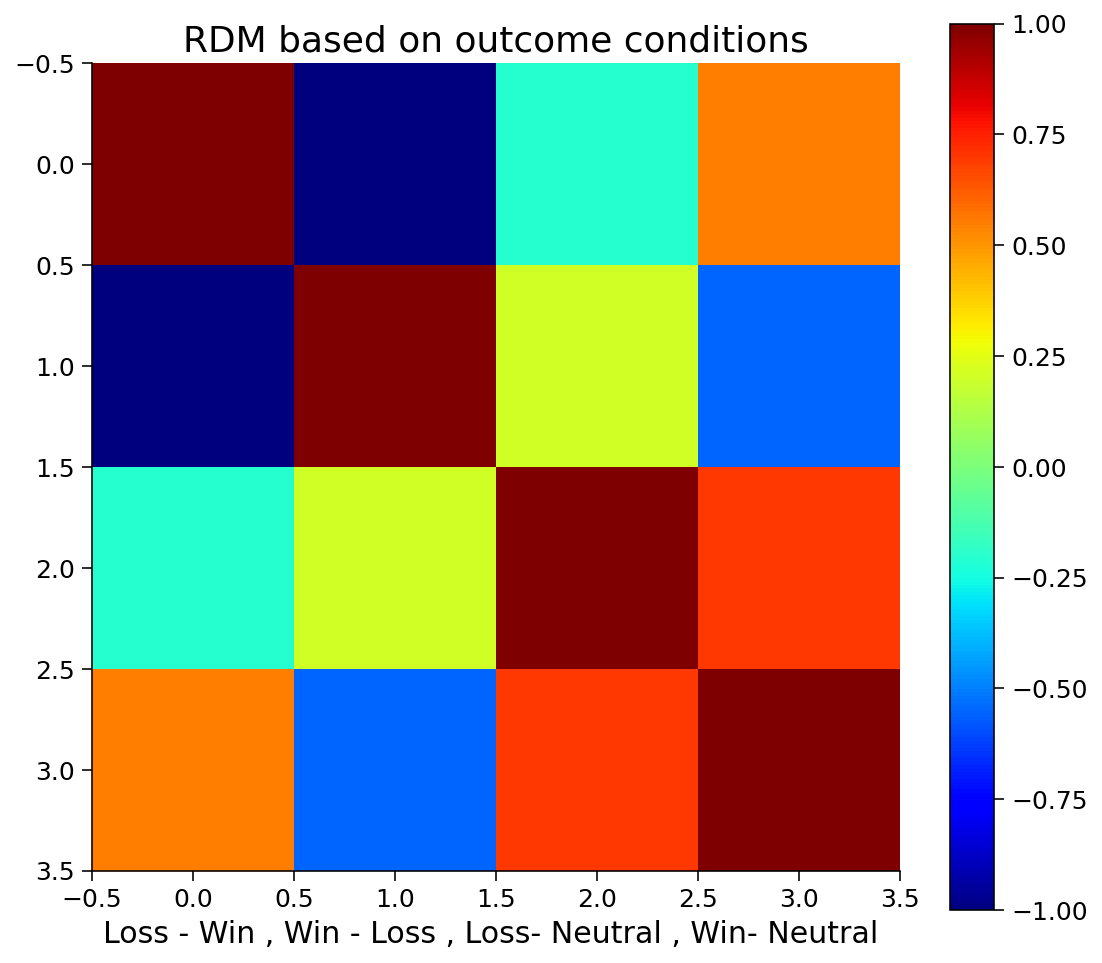

In [ ]:
# choose your ROI here!
roi = rois1

# plot figure of these correlations
f, ax = plt.subplots(1,1, figsize=(8, 7))

plt.imshow(
    np.corrcoef(roiiguess), 
    cmap='jet', 
)
plt.colorbar()
ax.set_title('RDM based on outcome conditions') 
ax.set_xlabel( 'Loss - Win , Win - Loss , Loss- Neutral , Win- Neutral ' )
#ax.set_ylabel('category type')
# this is basically roiforall conditions 

For Feedback Conditions


In [ ]:
def desion_evs(subject, experiment, run):
  """load EVs (explanatory variables) data and get the decision process
  Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = 'tfMRI_'+experiment+'_'+['RL','LR'][run]
  for cond in EXPERIMENTS[experiment]['cond']:    
    ev_file  = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)
    ev["duration"][:]=1.5
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)

  return frames_list


def feedback_evs(subject, experiment, run):
  """load EVs (explanatory variables) data and get the decision process
  Args:
    subject (int): 0-based subject ID to load
    experiment (str) : Name of experiment

  Returns
    evs (list of lists): A list of frames associated with each condition

  """
  frames_list = []
  task_key = 'tfMRI_'+experiment+'_'+['RL','LR'][run]
  for cond in EXPERIMENTS[experiment]['cond']:    
    ev_file  = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{cond}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"]+1.5 / TR).astype(int)
    ev["duration"][:]=1
    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)
    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
    frames_list.append(frames)
  return frames_list
# Create design martix for each subject
def get_design_matrix_seperate(subject, experiment, run):
  #load evs, data and hrf
  feedbackevs = feedback_evs(subject, experiment,run)
  desionevs = desion_evs(subject, experiment,run)
  data = load_single_timeseries(subject,experiment,run,remove_mean=True)
  hrf=double_gamma_hrf()
  
  # create a event array (regressor) for each feedback condition 
  InitialVextor=np.zeros(data.shape[1])
  for i in range(0,len(feedbackevs[0])):
    InitialVextor[feedbackevs[0][i]]=1;
  lossfeedback=InitialVextor;
  
  InitialVextor=np.zeros(data.shape[1])
  for i in range(0,len(feedbackevs[1])):
    InitialVextor[feedbackevs[1][i]]=1;
  winfeedback=InitialVextor;
  
  InitialVextor=np.zeros(data.shape[1])
  for i in range(0,len(feedbackevs[2])):
    InitialVextor[feedbackevs[2][i]]=1;
  neufeedback=InitialVextor;
  
    
  # create a event array (regressor) for each desicion condition 
  InitialVextor=np.zeros(data.shape[1])
  for i in range(0,len(desionevs[0])):
    InitialVextor[desionevs[0][i]]=1;
  lossdesion=InitialVextor;
  
  InitialVextor=np.zeros(data.shape[1])
  for i in range(0,len(desionevs[1])):
    InitialVextor[desionevs[1][i]]=1;
  windesion=InitialVextor;
  
  InitialVextor=np.zeros(data.shape[1])
  for i in range(0,len(desionevs[2])):
    InitialVextor[desionevs[2][i]]=1;
  neudesion=InitialVextor;
  
  #convolve regressors with the HRF
  n   = len(lossfeedback)
  ev1 = np.convolve(lossfeedback,hrf,'full')[:n]
  n   = len(winfeedback)
  ev2 = np.convolve(winfeedback,hrf,'full')[:n]
  n   = len(neufeedback)
  ev3 = np.convolve(neufeedback,hrf,'full')[:n]
  n   = len(lossdesion)
  ev4 = np.convolve(lossdesion,hrf,'full')[:n]
  n   = len(windesion)
  ev5 = np.convolve(windesion,hrf,'full')[:n]
  n   = len(neudesion)
  ev6 = np.convolve(neudesion,hrf,'full')[:n]
  
  # demean the task regressors
  ev1 = ev1 - np.mean(ev1)
  ev2 = ev2 - np.mean(ev2)
  ev3 = ev3 - np.mean(ev3)
  ev4 = ev4 - np.mean(ev4)
  ev5 = ev5 - np.mean(ev5)
  ev6 = ev6 - np.mean(ev6)
  
  # append a constant regressor
  design_matrix = np.asarray([ev1,ev2,ev3,ev4,ev5,ev6,np.ones_like(ev1)]).T
  design = np.asarray([ev1,ev2,ev3,ev4,ev5,ev6,np.ones_like(ev1)])
  return design_matrix


In [ ]:
import numpy as np
loss_win_feedbackgroupc=np.zeros((360,339))
loss_neu_feedbackgroupc=np.zeros((360,339))
win_neu_feedbackgroupc=np.zeros((360,339))

loss_win_decisiongroupc=np.zeros((360,339))
loss_neu_decisiongroupc=np.zeros((360,339))
win_neu_decisiongroupc=np.zeros((360,339))

loss_loss_groupc=np.zeros((360,339))
win_win_groupc=np.zeros((360,339))
neu_neu_groupc=np.zeros((360,339))
# loop wihin all subjects 
for s in subjects:
  for r in [0,1]:
    data = load_single_timeseries(subject=s,experiment=my_exp,run=r,remove_mean=True)
    design_matrix=get_design_matrix_seperate(subject=s,experiment=my_exp,run=r)
    
    Y = data.T
    mask = np.sum(Y**2,axis=0)>0

    # run GLM
    beta,betavar = glm(Y=Y,X=design_matrix,mask=mask)
 
    # add the individual result to group array using +=
    loss_win_feedbackgroupc[:,s]        += (beta[0] - beta[1]) / np.sqrt(betavar[0]+betavar[1])
    loss_neu_feedbackgroupc[:,s]        += (beta[0] - beta[2]) / np.sqrt(betavar[0]+betavar[2])
    win_neu_feedbackgroupc[:,s]         += (beta[1] - beta[2]) / np.sqrt(betavar[1]+betavar[2])
    loss_win_decisiongroupc[:,s]        += (beta[3] - beta[4]) / np.sqrt(betavar[3]+betavar[4])
    loss_neu_decisiongroupc[:,s]        += (beta[3] - beta[5]) / np.sqrt(betavar[3]+betavar[5])
    win_neu_decisiongroupc[:,s]         += (beta[4] - beta[5]) / np.sqrt(betavar[4]+betavar[5])
    loss_loss_groupc[:,s]  += (beta[0] - beta[3]) / np.sqrt(betavar[0]+betavar[3])
    win_win_groupc[:,s]  += (beta[1] - beta[4]) / np.sqrt(betavar[1]+betavar[4])
    neu_neu_groupc[:,s]  += (beta[2] - beta[5]) / np.sqrt(betavar[2]+betavar[5])
loss_win_feedback = np.mean(loss_win_feedbackgroupc)
loss_neu_feedback = np.mean(loss_neu_feedbackgroupc)
win_neu_feedback = np.mean(win_neu_feedbackgroupc)
loss_win_decision= np.mean(loss_win_decisiongroupc)
loss_neu_decision = np.mean(loss_neu_decisiongroupc)
win_neu_decision = np.mean(win_neu_decisiongroupc)
loss_lossgroup = np.mean(loss_loss_groupc)
win_wingroup = np.mean(win_win_groupc)
neu_neugroup= np.mean(neu_neu_groupc)
roiforrdm = np.array([])
roiforloss_winfeedback = loss_win_feedback
#roiforloss_winfeedback = np.append(roiforrdm)
#[loss_win_feedback,loss_neu_feedback,win_neu_feedback, loss_win_decision,loss_neu_decision,win_neu_decision,loss_lossgroup,win_wingroup,neu_neugroup])
print(loss_win_feedbackgroupc.shape)

(360, 339)


RDMS for feedback conditions


NameError: ignored

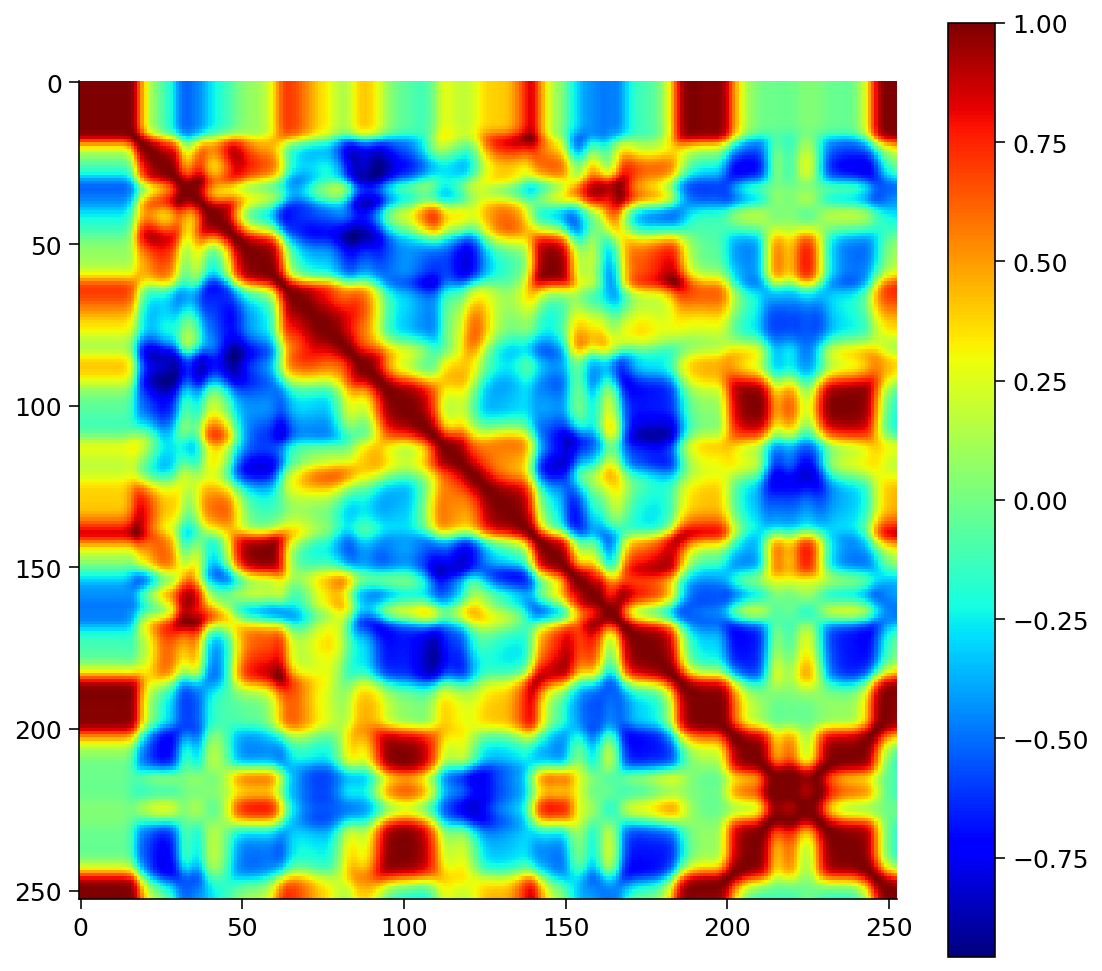

In [ ]:
# choose your ROI here!
#roi = rois1

# plot figure of these correlations
f, ax = plt.subplots(1,1, figsize=(8, 7))
plt.imshow(
    np.corrcoef(design_matrix), 
    cmap='jet', 
)
plt.colorbar()
ax.set_title('RSM, unsorted, %s' % (Feedback)) 
ax.set_xlabel('catergory type')
ax.set_ylabel('category type')
# this is basically roiforall conditions 

Text(0, 0.5, 'Win - Neutral Decision versus Win - Neutral Feedback')

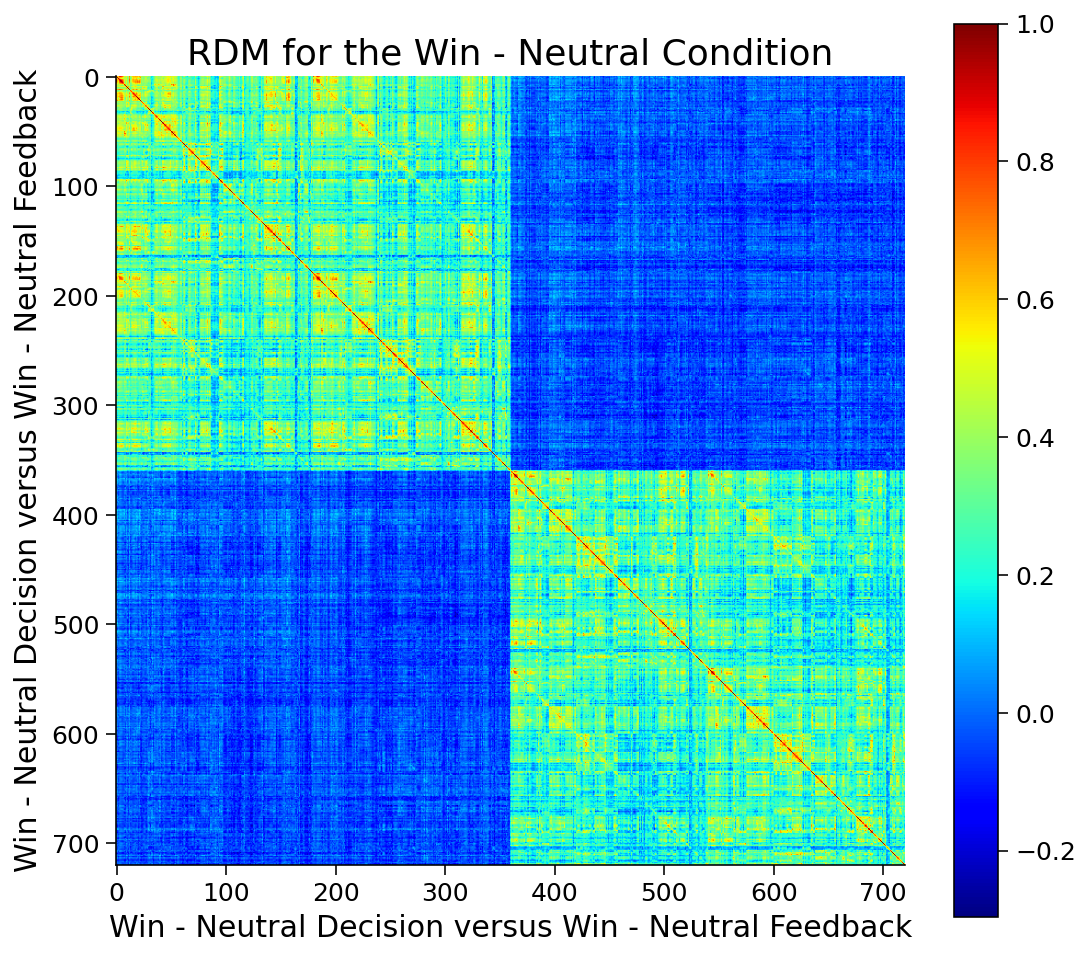

In [ ]:
# choose your ROI here!
#roi = rois1

# plot figure of these correlations
f, ax = plt.subplots(1,1, figsize=(8, 7))
plt.imshow(
    np.corrcoef(loss_win_feedbackgroupc,loss_win_decisiongroupc), 
    cmap='jet', 
)
plt.colorbar()
#ax.set_title('RDM for the Loss - Win Condition(WHOLE BRAIN)') 
ax.set_xlabel('Loss Win Feedback versus Loss Win Decision')
#x.set_ylabel('Loss Win Feedback versus Loss Win Decision')
# this is basically roiforall conditions 

plt.imshow(
    np.corrcoef(loss_neu_feedbackgroupc,loss_neu_decisiongroupc), 
    cmap= 'jet',
)
#plt.colorbar()
ax.set_title('RDM for the Loss -Neutral Condition')
ax.set_xlabel('Loss - Neutral Decision versus Loss Neutral Feedback')

plt.imshow(
    np.corrcoef(win_neu_decisiongroupc,win_neu_feedbackgroupc), 
    cmap= 'jet',
)
ax.set_title('RDM for the Win - Neutral Condition')
ax.set_xlabel('Win - Neutral Decision versus Win - Neutral Feedback')
ax.set_ylabel('Win - Neutral Decision versus Win - Neutral Feedback')


In [ ]:
# print out regions show significant diff (abs(t) > 2.5)
loss_win=[]
win_loss=[]
loss_neu=[]
win_neu=[]
for x in range(0,360):
  if abs(loss_win_second[x])> 2.5:
    loss_win.append(x)
  if abs(win_loss_second[x])> 2.5:
    win_loss.append(x) 
  if abs(win_neu_second[x])> 2.5:
    win_neu.append(x) 
  if abs(loss_neu_second[x])> 2.5:
    loss_neu.append(x)

c1=[region_info['name'][idx] for idx in loss_win]
print('loss - win： ')
print(c1)
c2=[region_info['name'][idx] for idx in win_loss]
print('win - loss： ')
print(c2)
c3=[region_info['name'][idx] for idx in loss_neu]
print('loss - neu： ')
print(c3)
c4=[region_info['name'][idx] for idx in win_neu]
print('win - neu： ')
print(c4)

loss - win： 
['R_V3', 'L_IPS1', 'L_V3B', 'L_PH']
win - loss： 
['R_V3', 'L_IPS1', 'L_V3B', 'L_PH']
loss - neu： 
['R_POS2', 'R_STV', 'R_7m', 'R_POS1', 'R_31pv', 'R_7PL', 'R_MIP', 'R_2', 'R_8Ad', 'R_IFJa', 'R_IFSp', 'R_IFSa', 'R_PFt', 'R_AIP', 'R_STSda', 'R_STSvp', 'R_TE1p', 'R_TF', 'R_TE2p', 'R_PHT', 'R_PH', 'R_TPOJ1', 'R_TPOJ2', 'R_DVT', 'R_PGp', 'R_IP1', 'R_IP0', 'R_PF', 'R_PGi', 'R_PGs', 'R_FST', 'R_31pd', 'R_31a', 'R_p10p', 'R_STSva', 'L_POS2', 'L_7m', 'L_d23ab', 'L_31pv', 'L_7PL', 'L_MIP', 'L_8Ad', 'L_10d', 'L_8C', 'L_IFJa', 'L_IFSp', 'L_IFSa', 'L_6a', 'L_i6-8', 'L_AIP', 'L_PeEc', 'L_TE1p', 'L_TF', 'L_TE2p', 'L_PHT', 'L_PH', 'L_TPOJ1', 'L_DVT', 'L_PGp', 'L_IP2', 'L_IP1', 'L_IP0', 'L_PGi', 'L_PGs', 'L_FST', 'L_31pd', 'L_p10p']
win - neu： 
['R_POS2', 'R_7m', 'R_31pv', 'R_8Av', 'R_8Ad', 'R_8BL', 'R_9a', 'R_10pp', 'R_PeEc', 'R_STSda', 'R_STSvp', 'R_TGd', 'R_TE1a', 'R_TE1p', 'R_TE2a', 'R_TF', 'R_TE2p', 'R_PHT', 'R_TPOJ1', 'R_PGp', 'R_IP1', 'R_PF', 'R_PFm', 'R_PGi', 'R_PGs', 'R_31pd', 'R_

Plot t-map

In [ ]:
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = loss_neu_second[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast, 
                   threshold=2.5,
                   vmax=15)

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))


In [ ]:
fsaverage = datasets.fetch_surf_fsaverage()
surf_contrast = win_neu_second[atlas["labels_L"]]
plotting.view_surf(fsaverage['infl_left'],
                   surf_contrast, 
                   threshold=2.5,
                   vmax=15)

/usr/local/lib/python3.7/dist-packages/nilearn/plotting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))


## Single subject analysis

Step0. add another helper function : get data for each subj and each condition without averaging


In [ ]:
def get_frames(data, evs, experiment, cond): 
  #initial the array
  idx = EXPERIMENTS[experiment]['cond'].index(cond)
  neray = np.zeros((len(evs[idx]),360,5))
  for i in range(len(evs[idx])):
    neray[i,:,:]=np.array(data[:,evs[idx][i]])
  return neray

Step1. Load data and ev.

In [ ]:
my_exp  = 'GAMBLING'
my_subj = 2
my_run  = 0

data = load_single_timeseries(subject=my_subj,experiment=my_exp,run=my_run,remove_mean=True)
evs = load_evs(subject=my_subj, experiment=my_exp,run=my_run)

Step2. get the activity within diff conditions 

In [ ]:
loss_activity = get_frames(data, evs, my_exp, 'loss_event')
win_activity = get_frames(data, evs, my_exp, 'win_event')
neu_activity = get_frames(data, evs, my_exp, 'neut_event')

print(neu_activity.shape)
# = trial number * ROI * data points within each trial

(4, 360, 5)


Step3. plot a regoins activity 

Here I chosed OFC. The orbitofrontal cortex (OFC) is a prefrontal cortex region in the frontal lobes of the brain which is involved in the cognitive process of decision-making.
loc92 272

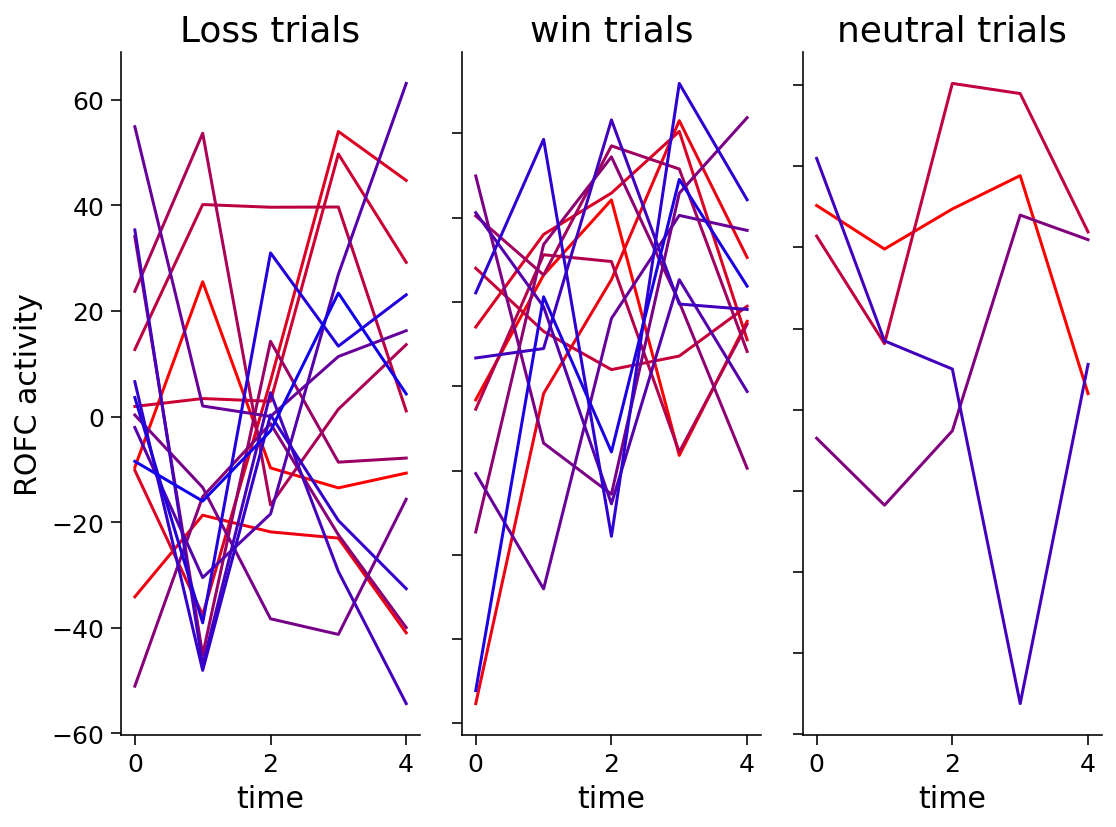

In [ ]:
fig, axs = plt.subplots(1, 3)

#set colors for trials:
R=range(255, 0, -int(255/loss_activity.shape[0]))
B=range(0, 255, int(255/loss_activity.shape[0]))
for nt in range(0,loss_activity.shape[0]): 
  axs[0].plot(loss_activity[nt,92,:],label='trial'+str(nt+1),color=([R[nt]/255,0,B[nt]/255]))
axs[0].set_title('Loss trials')

#set colors for trials:
R=range(255, 0, -int(255/win_activity.shape[0]))
B=range(0, 255, int(255/win_activity.shape[0]))
for nt in range(0,win_activity.shape[0]): 
  axs[1].plot(win_activity[nt,92,:],label='trial'+str(nt+1),color=([R[nt]/255,0,B[nt]/255]))
axs[1].set_title('win trials')

#set colors for trials:
R=range(255, 0, -int(255/neu_activity.shape[0]))
B=range(0, 255, int(255/neu_activity.shape[0]))
for nt in range(0,neu_activity.shape[0]): 
  axs[2].plot(neu_activity[nt,92,:],label='trial'+str(nt+1),color=([R[nt]/255,0,B[nt]/255]))
axs[2].set_title('neutral trials')

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='ROFC activity')
    # Hide x labels and tick labels for top plots and y ticks for right plots
    ax.label_outer()

#('first trial → last trial: red → blue')

## Group plotting

In [ ]:
#for run0
my_exp  = 'GAMBLING'
my_run  = 0

group_Loss = [] 
group_Win=[]
group_neu=[]

for s in subjects:
  data = load_single_timeseries(subject=s,experiment=my_exp,run=my_run,remove_mean=True)
  evs = load_evs(subject=s, experiment=my_exp,run=my_run)

  loss_activity = get_frames(data, evs, my_exp, 'loss_event')
  win_activity = get_frames(data, evs, my_exp, 'win_event')
  neu_activity = get_frames(data, evs, my_exp, 'neut_event')

  group_Loss.append(loss_activity[:,92,:])    
  group_Win.append(win_activity[:,92,:]) 
  group_neu.append(neu_activity[:,92,:]) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


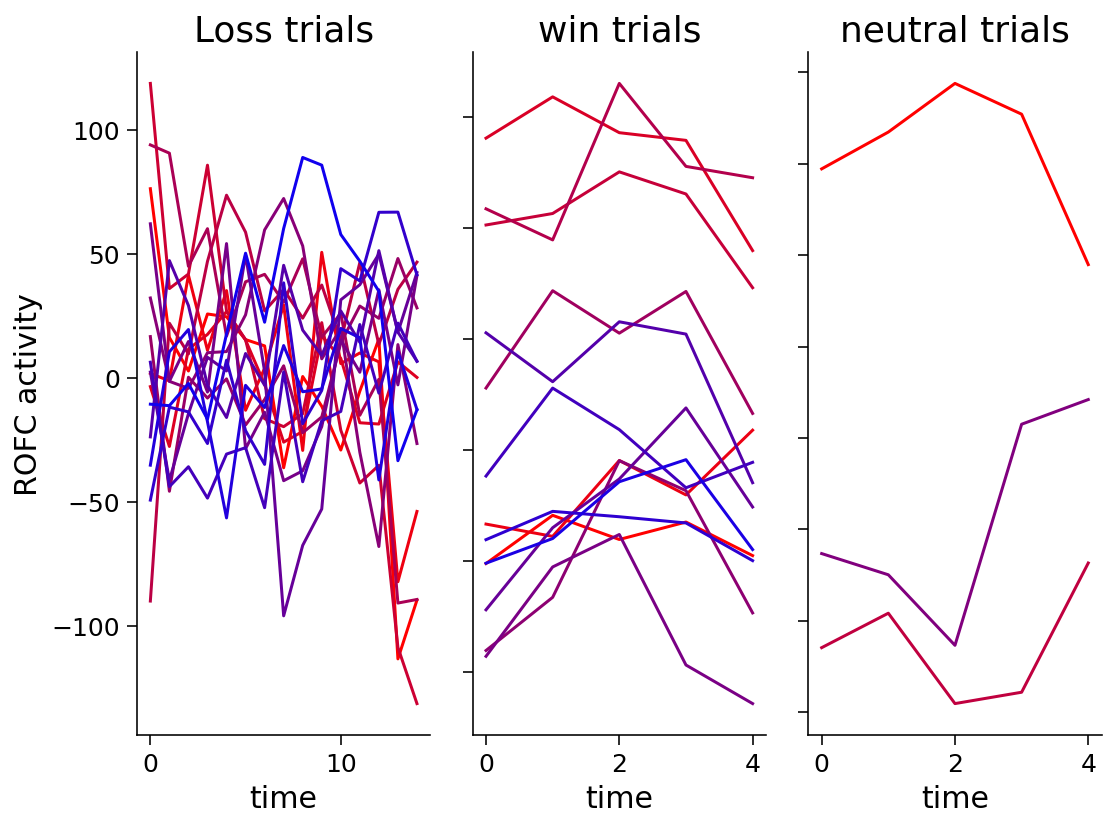

In [ ]:
fig, axs = plt.subplots(1, 3)
#set colors for trials:
R=range(255, 0, -int(255/loss_activity.shape[0]))
B=range(0, 255, int(255/loss_activity.shape[0]))
ac=np.array(list(itertools.zip_longest(*group_Loss,fillvalue=np.nan))).T
ac=np.mean(ac, axis=0)
for nt in range(0,loss_activity.shape[0]): 
  axs[0].plot(ac[nt],label='trial'+str(nt+1),color=([R[nt]/255,0,B[nt]/255]))
axs[0].set_title('Loss trials')

#set colors for trials:
R=range(255, 0, -int(255/win_activity.shape[0]))
B=range(0, 255, int(255/win_activity.shape[0]))
ac=np.array(list(itertools.zip_longest(*group_Win,fillvalue=np.nan))).T
ac=np.mean(ac, axis=0)

for nt in range(0,win_activity.shape[0]): 
  axs[1].plot(ac[nt],label='trial'+str(nt+1),color=([R[nt]/255,0,B[nt]/255]))
axs[1].set_title('win trials')

#set colors for trials:
R=range(255, 0, -int(255/neu_activity.shape[0]))
B=range(0, 255, int(255/neu_activity.shape[0]))
ac=np.array(list(itertools.zip_longest(*group_neu,fillvalue=np.nan))).T
ac=np.mean(ac, axis=0)
for nt in range(0,neu_activity.shape[0]): 
  axs[2].plot(ac[nt],label='trial'+str(nt+1),color=([R[nt]/255,0,B[nt]/255]))
axs[2].set_title('neutral trials')

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='ROFC activity')
    # Hide x labels and tick labels for top plots and y ticks for right plots
    ax.label_outer()

#('first trial → last trial: red → blue')

In [ ]:
#for run1

my_exp  = 'GAMBLING'
my_run  = 1

group_Loss = [] 
group_Win=[]
group_neu=[]

for s in subjects:
  data = load_single_timeseries(subject=s,experiment=my_exp,run=my_run,remove_mean=True)
  evs = load_evs(subject=s, experiment=my_exp,run=my_run)

  loss_activity = get_frames(data, evs, my_exp, 'loss_event')
  win_activity = get_frames(data, evs, my_exp, 'win_event')
  neu_activity = get_frames(data, evs, my_exp, 'neut_event')

  group_Loss.append(loss_activity[:,92,:])    
  group_Win.append(win_activity[:,92,:]) 
  group_neu.append(neu_activity[:,92,:]) 
  



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


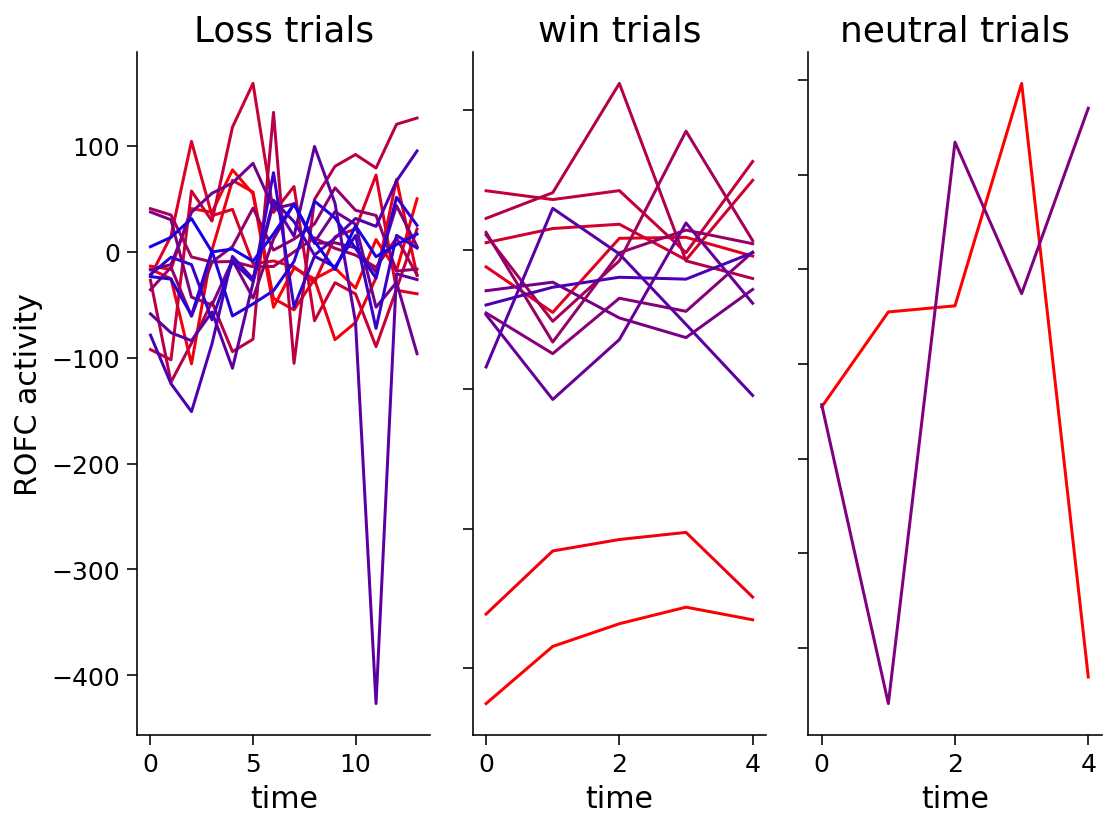

In [ ]:
fig, axs = plt.subplots(1, 3)

#set colors for trials:
R=range(255, 0, -int(255/loss_activity.shape[0]))
B=range(0, 255, int(255/loss_activity.shape[0]))
ac=np.array(list(itertools.zip_longest(*group_Loss,fillvalue=np.nan))).T
ac=np.mean(ac, axis=0)
for nt in range(0,loss_activity.shape[0]): 
  axs[0].plot(ac[nt],label='trial'+str(nt+1),color=([R[nt]/255,0,B[nt]/255]))
axs[0].set_title('Loss trials')

#set colors for trials:
R=range(255, 0, -int(255/win_activity.shape[0]))
B=range(0, 255, int(255/win_activity.shape[0]))
ac=np.array(list(itertools.zip_longest(*group_Win,fillvalue=np.nan))).T
ac=np.mean(ac, axis=0)

for nt in range(0,win_activity.shape[0]): 
  axs[1].plot(ac[nt],label='trial'+str(nt+1),color=([R[nt]/255,0,B[nt]/255]))
axs[1].set_title('win trials')

#set colors for trials:
R=range(255, 0, -int(255/neu_activity.shape[0]))
B=range(0, 255, int(255/neu_activity.shape[0]))
ac=np.array(list(itertools.zip_longest(*group_neu,fillvalue=np.nan))).T
ac=np.mean(ac, axis=0)
for nt in range(0,neu_activity.shape[0]): 
  axs[2].plot(ac[nt],label='trial'+str(nt+1),color=([R[nt]/255,0,B[nt]/255]))
axs[2].set_title('neutral trials')

for ax in axs.flat:
    ax.set(xlabel='time', ylabel='ROFC activity')
    # Hide x labels and tick labels for top plots and y ticks for right plots
    ax.label_outer()

#('first trial → last trial: red → blue')

step5 distinguish win trials in loss block & loss trial in win block

In [ ]:
#run0
my_exp  = 'GAMBLING'
my_run  = 0
group_winBloss=[]
group_winBwin=[]
group_winBneu=[];  
group_lossBloss=[];  
group_lossBwin=[];   
group_lossBneu=[] 
  
for s in subjects:
  data = load_single_timeseries(subject=s,experiment=my_exp,run=my_run,remove_mean=True)
  evs = load_evs(subject=s, experiment=my_exp,run=my_run)

  loss_activity = get_frames(data, evs, my_exp, 'loss_event')
  win_activity = get_frames(data, evs, my_exp, 'win_event')
  neu_activity = get_frames(data, evs, my_exp, 'neut_event')

  winB_loss=[]; #loss trials in win block
  winB_win=[]; #win trials in win block
  winB_neu=[]; #neu trials in win block
  lossB_loss=[];
  lossB_win=[];
  lossB_neu=[];
  
  # win block
  for ij in (0,1):
    for ii in range(0,len(evs[0])-1):
      winB_loss.append([i for i in evs[0][ii] if i >= evs[4][ij][0] and i <= evs[4][ij][len(evs[4][ij])-1]])
    for ii in range(0,len(evs[1])-1):
      winB_win.append([i for i in evs[1][ii] if i >= evs[4][ij][0] and i <= evs[4][ij][len(evs[4][ij])-1]])
    for ii in range(0,len(evs[2])-1):
      winB_neu.append([i for i in evs[2][ii] if i >= evs[4][ij][0] and i <= evs[4][ij][len(evs[4][ij])-1]])
    #loss block
    for ii in range(0,len(evs[0])-1):
      lossB_loss.append([i for i in evs[0][ii] if i >= evs[3][ij][0] and i <= evs[3][ij][len(evs[3][ij])-1]])
    for ii in range(0,len(evs[1])-1):
      lossB_win.append([i for i in evs[1][ii] if i >= evs[3][ij][0] and i <= evs[3][ij][len(evs[3][ij])-1]])
    for ii in range(0,len(evs[2])-1):
      lossB_neu.append([i for i in evs[2][ii] if i >= evs[3][ij][0] and i <= evs[3][ij][len(evs[3][ij])-1]])
  
  winB_loss = [x for x in winB_loss if x != []]
  winB_win=[x for x in winB_win if x != []]
  winB_neu=[x for x in winB_neu if x != []]
  lossB_loss=[x for x in lossB_win if x != []]
  lossB_win=[x for x in lossB_win if x != []]
  lossB_neu=[x for x in lossB_win if x != []]
  
  group_winBloss.append(np.mean(np.concatenate([np.mean(data[92,winB_loss[i]],axis=0,keepdims=True) for i in range(len(winB_loss))],axis=-1),axis=0))    
  group_winBwin.append(np.mean(np.concatenate([np.mean(data[92,winB_win[i]],axis=0,keepdims=True) for i in range(len(winB_win))],axis=-1),axis=0))    
  group_winBneu.append(np.mean(np.concatenate([np.mean(data[92,winB_neu[i]],axis=0,keepdims=True) for i in range(len(winB_neu))],axis=-1),axis=0))    
  group_lossBloss.append(np.mean(np.concatenate([np.mean(data[92,lossB_loss[i]],axis=0,keepdims=True) for i in range(len(lossB_loss))],axis=-1),axis=0))    
  group_lossBwin.append(np.mean(np.concatenate([np.mean(data[92,lossB_win[i]],axis=0,keepdims=True) for i in range(len(lossB_win))],axis=-1),axis=0))    
  group_lossBneu.append(np.mean(np.concatenate([np.mean(data[92,lossB_neu[i]],axis=0,keepdims=True) for i in range(len(lossB_neu))],axis=-1),axis=0))    
  


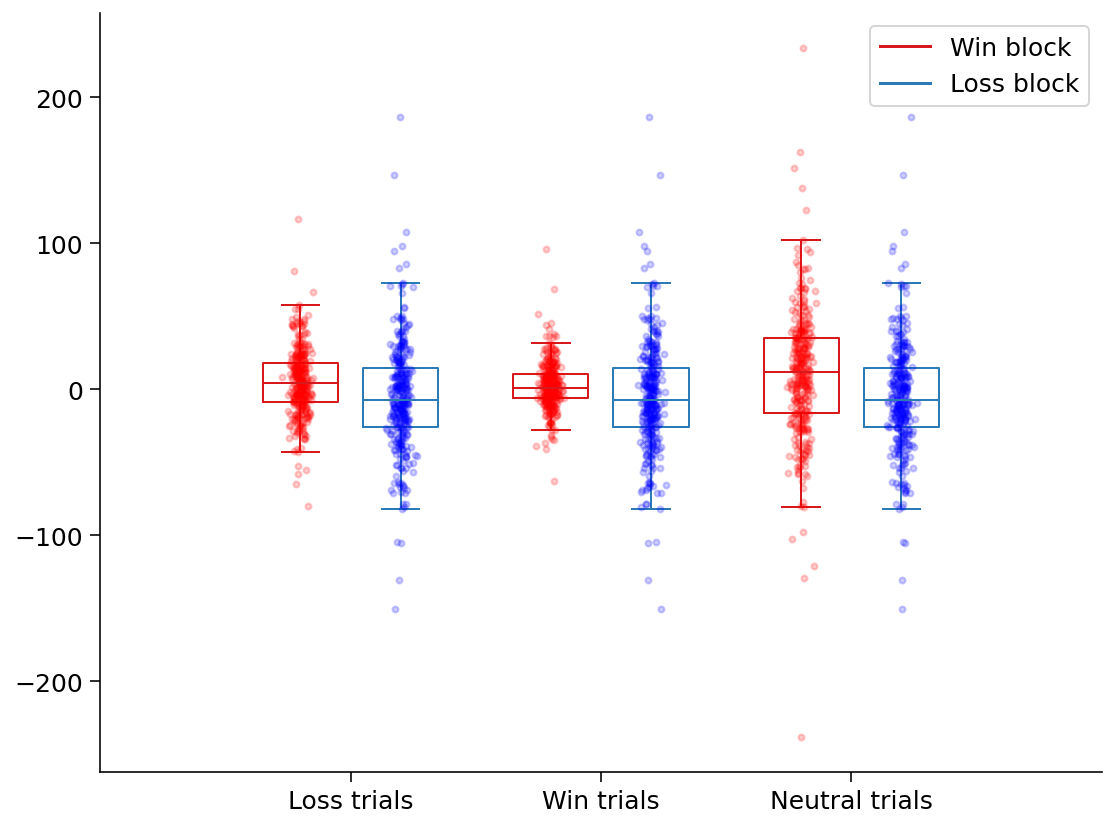

In [ ]:
data_a = [group_winBloss,group_winBwin,group_winBneu]
data_b = [group_lossBloss,group_lossBwin,group_lossBneu]

ticks = ['Loss trials', 'Win trials', 'Neutral trials']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') 
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Win block')
plt.plot([], c='#2C7BB6', label='Loss block')
plt.legend()
 

positions=np.array(range(len(data_a)))*2.0-0.4
for i in range(0,3):
    # select the RT based on conditions
    y =data_a[i]
    # Add some random "jitter" to the x-axis
    x = np.random.normal(positions[i], 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.2)

positions=np.array(range(len(data_b)))*2.0+0.4
for i in range(0,3):
    y =data_b[i] 
    # Add some random "jitter" to the x-axis
    x = np.random.normal(positions[i], 0.04, size=len(y))
    plt.plot(x, y, 'b.', alpha=0.2)


plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
#plt.ylim(0, 8)
plt.tight_layout()

In [ ]:
#run1 (2)
my_exp  = 'GAMBLING'
my_run  = 1
group_winBloss=[]
group_winBwin=[]
group_winBneu=[];  
group_lossBloss=[];  
group_lossBwin=[];   
group_lossBneu=[] 
  
for s in subjects:
  data = load_single_timeseries(subject=s,experiment=my_exp,run=my_run,remove_mean=True)
  evs = load_evs(subject=s, experiment=my_exp,run=my_run)

  loss_activity = get_frames(data, evs, my_exp, 'loss_event')
  win_activity = get_frames(data, evs, my_exp, 'win_event')
  neu_activity = get_frames(data, evs, my_exp, 'neut_event')

  winB_loss=[]; #loss trials in win block
  winB_win=[]; #win trials in win block
  winB_neu=[]; #neu trials in win block
  lossB_loss=[];
  lossB_win=[];
  lossB_neu=[];
  
  # win block
  for ij in (0,1):
    for ii in range(0,len(evs[0])-1):
      winB_loss.append([i for i in evs[0][ii] if i >= evs[4][ij][0] and i <= evs[4][ij][len(evs[4][ij])-1]])
    for ii in range(0,len(evs[1])-1):
      winB_win.append([i for i in evs[1][ii] if i >= evs[4][ij][0] and i <= evs[4][ij][len(evs[4][ij])-1]])
    for ii in range(0,len(evs[2])-1):
      winB_neu.append([i for i in evs[2][ii] if i >= evs[4][ij][0] and i <= evs[4][ij][len(evs[4][ij])-1]])
    #loss block
    for ii in range(0,len(evs[0])-1):
      lossB_loss.append([i for i in evs[0][ii] if i >= evs[3][ij][0] and i <= evs[3][ij][len(evs[3][ij])-1]])
    for ii in range(0,len(evs[1])-1):
      lossB_win.append([i for i in evs[1][ii] if i >= evs[3][ij][0] and i <= evs[3][ij][len(evs[3][ij])-1]])
    for ii in range(0,len(evs[2])-1):
      lossB_neu.append([i for i in evs[2][ii] if i >= evs[3][ij][0] and i <= evs[3][ij][len(evs[3][ij])-1]])
  
  winB_loss = [x for x in winB_loss if x != []]
  winB_win=[x for x in winB_win if x != []]
  winB_neu=[x for x in winB_neu if x != []]
  lossB_loss=[x for x in lossB_win if x != []]
  lossB_win=[x for x in lossB_win if x != []]
  lossB_neu=[x for x in lossB_win if x != []]
  
  group_winBloss.append(np.mean(np.concatenate([np.mean(data[92,winB_loss[i]],axis=0,keepdims=True) for i in range(len(winB_loss))],axis=-1),axis=0))    
  group_winBwin.append(np.mean(np.concatenate([np.mean(data[92,winB_win[i]],axis=0,keepdims=True) for i in range(len(winB_win))],axis=-1),axis=0))    
  group_winBneu.append(np.mean(np.concatenate([np.mean(data[92,winB_neu[i]],axis=0,keepdims=True) for i in range(len(winB_neu))],axis=-1),axis=0))    
  group_lossBloss.append(np.mean(np.concatenate([np.mean(data[92,lossB_loss[i]],axis=0,keepdims=True) for i in range(len(lossB_loss))],axis=-1),axis=0))    
  group_lossBwin.append(np.mean(np.concatenate([np.mean(data[92,lossB_win[i]],axis=0,keepdims=True) for i in range(len(lossB_win))],axis=-1),axis=0))    
  group_lossBneu.append(np.mean(np.concatenate([np.mean(data[92,lossB_neu[i]],axis=0,keepdims=True) for i in range(len(lossB_neu))],axis=-1),axis=0))    
  


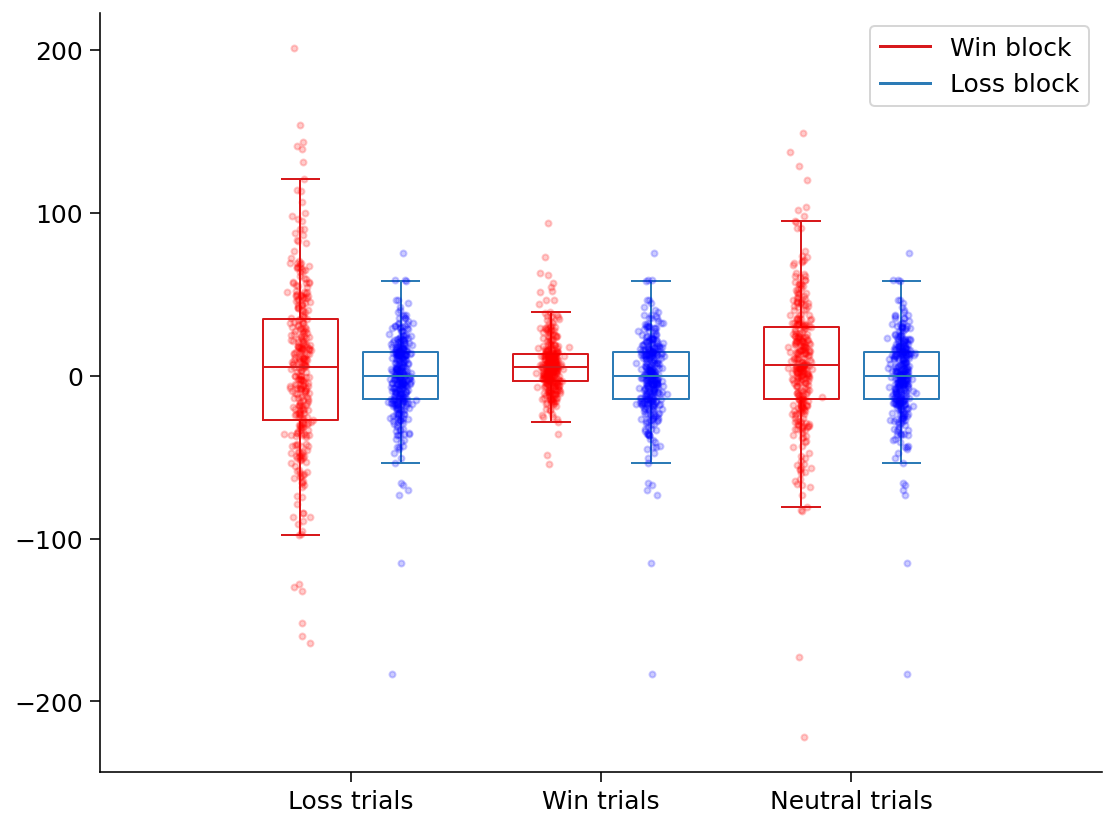

In [ ]:
data_a = [group_winBloss,group_winBwin,group_winBneu]
data_b = [group_lossBloss,group_lossBwin,group_lossBneu]

# delete outliers
for j in range(0,len(data_a)):
  data_a[j]= [x for x in data_a[j] if (-500 < x < 500)]
  data_b[j]= [x for x in data_b[j] if (-500 < x < 500)]

ticks = ['Loss trials', 'Win trials', 'Neutral trials']

def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bpl = plt.boxplot(data_a, positions=np.array(range(len(data_a)))*2.0-0.4, sym='', widths=0.6)
bpr = plt.boxplot(data_b, positions=np.array(range(len(data_b)))*2.0+0.4, sym='', widths=0.6)
set_box_color(bpl, '#D7191C') 
set_box_color(bpr, '#2C7BB6')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Win block')
plt.plot([], c='#2C7BB6', label='Loss block')
plt.legend()
 

positions=np.array(range(len(data_a)))*2.0-0.4
for i in range(0,3):
    # select the RT based on conditions
    y =data_a[i]
    # Add some random "jitter" to the x-axis
    x = np.random.normal(positions[i], 0.04, size=len(y))
    plt.plot(x, y, 'r.', alpha=0.2)

positions=np.array(range(len(data_b)))*2.0+0.4
for i in range(0,3):
    y =data_b[i] 
    # Add some random "jitter" to the x-axis
    x = np.random.normal(positions[i], 0.04, size=len(y))
    plt.plot(x, y, 'b.', alpha=0.2)


plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
#plt.ylim(-250, 250)
plt.tight_layout()